In [1]:
import sys
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
tt = torch.tensor
from torch.nn.functional import softmax
import pyro
from pyro.distributions import Binomial, Normal, Bernoulli, Categorical, LogNormal, Poisson, Exponential, Uniform
from pyro.ops.stats import hpdi
import networkx as nx
import arviz as az

#torch.multiprocessing.set_sharing_strategy("file_system")
from utils import (
    HPDI,
    WAIC,
    sample_posterior,
    sample_prior,
    format_data,
    train_nuts,
    traceplot,
    trankplot,
    plot_intervals,
    precis,
)
from models import RegressionBase

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Aug 21 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

arviz     : 0.17.1
numpy     : 1.26.4
pandas    : 2.2.2
networkx  : 3.1
matplotlib: 3.9.0
torch     : 2.3.0
pyro      : 1.9.1
sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]

Watermark: 2.4.3



### Code 11.1 - 11.9
We will now start examining binomial GLM's, using some data from a social experiment on chimpanzees. The basic setup is a "focal" subject sits on one end of a table, with 4 trays (2 on each of the left/right sides) in the middle. 3 of the 4 trays have food on them, the other has nothing. The subject gets 2 levers on either side, and pulling one of them causes the food on that side of the table to move towards opposite ends of the table. Sometimes, there is another subject on the opposite end of the table (with no levers to control themselves), and we want to see whether the presence/absence of the other subject influences the focal subject's decision to pull either lever, the idea being that if there is another subject, the focal subject may want to choose the "prosocial" behavior and pull the lever that leads to both subjects getting food.

In [3]:
chimp_df = pd.read_csv("data/chimpanzees.csv", sep=";")
print("# rows:", len(chimp_df))
chimp_df[["actor", "condition", "prosoc_left", "pulled_left"]].sample(5)

# rows: 504


,actor,condition,prosoc_left,pulled_left
14,1,0,0,0
309,5,0,1,0
15,1,0,1,1
21,1,0,0,0
223,4,0,1,0


In [4]:
print("# actors:", chimp_df["actor"].nunique())

# actors: 7


In [5]:
d = chimp_df.copy()
d["treatment"] = d["prosoc_left"] + 2*d["condition"]
d["actor"] -= 1
print(d["treatment"].unique())
d[["actor", "condition", "prosoc_left", "treatment", "pulled_left"]].sample(5)

[0 1 2 3]


,actor,condition,prosoc_left,treatment,pulled_left
99,1,0,1,1,1
238,3,0,0,0,1
233,3,0,0,0,1
353,4,1,0,2,1
319,4,0,1,1,0


Let's build a super simple model just to visualize the effect of the priors. We'll try a simple model where $\text{logit}(p) = \alpha$, and have $\alpha \sim \text{Normal}(0, \omega)$, where $\omega \in \{1.5, 10.\}$.

In [6]:
def inv_logit(x):
    return torch.exp(x)/(1+torch.exp(x))

In [7]:
class M11_1(RegressionBase):
    def __init__(self, df, a_std):
        super().__init__(df)
        self.a_std = a_std
        
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(0., self.a_std))
        p = pyro.deterministic("p", inv_logit(a))
        if data is None:
            pyro.sample("pulled_left", Bernoulli(p), obs=self.pulled_left)
        else:
            pyro.sample("pulled_left", Bernoulli(p))
        
m11_1_1 = M11_1(d[["pulled_left"]], a_std=10.)
m11_1_2 = M11_1(d[["pulled_left"]], a_std=1.5)

In [8]:
s = {10: sample_prior(m11_1_1, 10000, ("p",)), 1.5: sample_prior(m11_1_2, 10000, ("p",))}

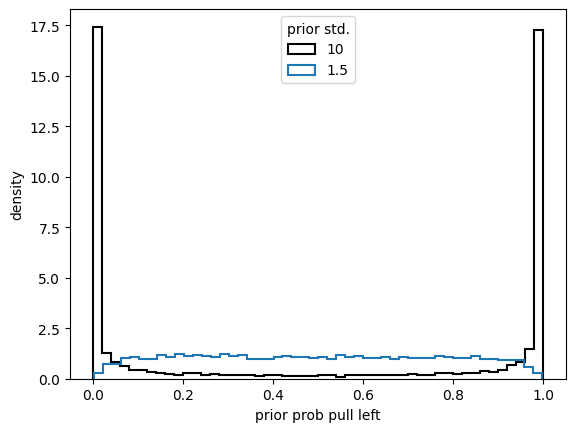

In [9]:
plt.hist(s[10]["p"], bins=50, color="black", histtype="step", linewidth=1.5, density=True, label=10)
plt.hist(s[1.5]["p"], bins=50, color="C0", histtype="step", linewidth=1.5, density=True, label=1.5)
plt.legend(title="prior std.", loc="upper center")
plt.xlabel("prior prob pull left")
plt.ylabel("density")
plt.show()

Because of the nonlinear transformation, all the probability mass gets pushed to the ends of the domain when $\omega = 10$, which is not flat at all! It is much more reasonable to choose a smaller std that results in a flatter prior in the transformed space.

Now let's try and include the effect of $\beta$ on the outcome.

In [10]:
class M11_2(RegressionBase):
    def __init__(self, df, b_std):
        super().__init__(df, categoricals=("treatment",))
        self.b_std = b_std
        self.b_card = df["treatment"].nunique()
        
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(0., 1.5))
        b = pyro.sample("b", Normal(0, self.b_std).expand([self.b_card]).to_event(1))
        if data is None:
            p = pyro.deterministic("p", inv_logit(a + b[self.treatment]))
            pyro.sample("pulled_left", Bernoulli(p), obs=self.pulled_left)
        else:
            p = pyro.deterministic("p", inv_logit(a + b[data["treatment"]]))
            return pyro.sample("pulled_left", Bernoulli(p))
        
m11_2_1 = M11_2(d[["pulled_left", "treatment"]], b_std=10.)
m11_2_2 = M11_2(d[["pulled_left", "treatment"]], b_std=0.5)

In [11]:
s = {k: sample_prior(m, 10000, ("a", "b",)) for m, k in zip((m11_2_1, m11_2_2), (10, 0.5))}

We are interested in looking at what the priors imply about the _differences_ between treatments. Let's plot the absolute prior difference between the first two treatments

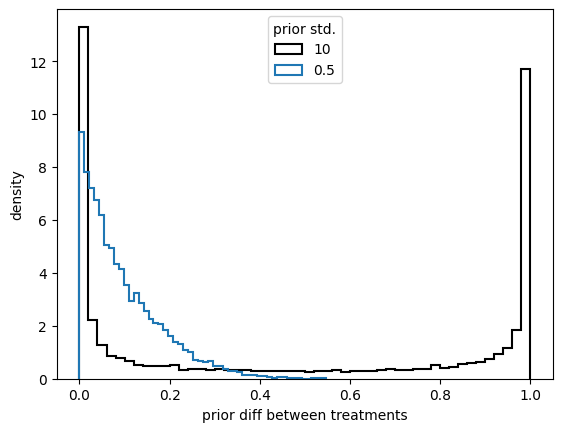

In [12]:
p = s[10]["a"][:,None] + s[10]["b"]
p = np.exp(p)/(1+np.exp(p))
diff = abs(p[:,0] - p[:,1])
plt.hist(diff, bins=50, color="black", histtype="step", linewidth=1.5, density=True, label=10)
p = s[0.5]["a"][:,None] + s[0.5]["b"]
p = np.exp(p)/(1+np.exp(p))
diff = abs(p[:,0] - p[:,1])
plt.hist(diff, bins=50, color="C0", histtype="step", linewidth=1.5, density=True, label=0.5)
plt.legend(title="prior std.", loc="upper center")
plt.xlabel("prior diff between treatments")
plt.ylabel("density")
plt.show()

In [13]:
diff.mean()

0.09750361

The prior with $\omega=0.5$ looks much more reasonable than the prior with $\omega = 10$. The difference in treatments is on average about 10%, with most of the probability mass concentrated near zero. This is likely what we would expect.

### Code 11.10 - 11.16
Now let's do inference on the full model using HMC.

In [14]:
data = {col: tt(d[col]).long() for col in ("actor", "treatment", "pulled_left")}
n_actor = d["actor"].nunique()
n_treat = d["treatment"].nunique()

def model_m11_4(data, training=False):
    a = pyro.sample("a", Normal(0, 1.5).expand([n_actor]).to_event(1))
    b = pyro.sample("b", Normal(0, 0.5).expand([n_treat]).to_event(1))
    p = inv_logit(a[data["actor"]] + b[data["treatment"]])
    if training:
        pyro.sample("pulled_left", Bernoulli(p), obs=data["pulled_left"].double())
    else:
        return pyro.sample("pulled_left", Bernoulli(p))
    
m11_4 = train_nuts(model_m11_4, data, 3000, 3000, 1)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 6000/6000 [00:17, 335.00it/s, step size=4.24e-01, acc. prob=0.909]


In [15]:
m11_4.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.45      0.33     -0.45     -0.98      0.07   1068.16      1.00
      a[1]      3.90      0.74      3.85      2.73      5.05   2355.35      1.00
      a[2]     -0.74      0.33     -0.74     -1.26     -0.17   1035.16      1.00
      a[3]     -0.74      0.33     -0.74     -1.31     -0.22   1111.24      1.00
      a[4]     -0.44      0.32     -0.45     -0.94      0.11   1007.37      1.00
      a[5]      0.48      0.32      0.49     -0.05      1.01   1060.35      1.00
      a[6]      1.96      0.41      1.95      1.33      2.64   1410.38      1.00
      b[0]     -0.05      0.28     -0.05     -0.49      0.39    837.54      1.00
      b[1]      0.48      0.28      0.47      0.03      0.95    974.20      1.00
      b[2]     -0.38      0.27     -0.38     -0.82      0.07    910.73      1.00
      b[3]      0.36      0.27      0.36     -0.08      0.83    920.98      1.00

Number of divergences: 0


In [16]:
s = m11_4.get_samples(group_by_chain=True).copy()
for var in ("a", "b"):
    for i in range(s[var].shape[-1]):
        s[f"{var}[{i}]"] = s[var][...,i]
    del s[var]

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

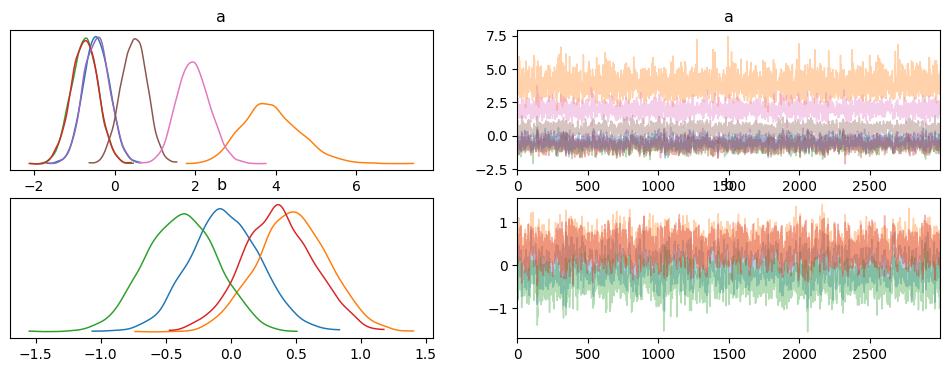

In [17]:
az.plot_trace(az.from_pyro(m11_4))

Let's plot the transformed intercept $f^{-1}(\alpha)$, since it is a show of the "base probability" that an individual chimp has to pull the left lever. Subject 1 specifically pulled the left lever literally every time, so they have an extremely high probability.

In [18]:
def unnest_samples(samples: dict, group_by_chain=False, depth=1):
    """Unnests samples from multivariate distributions
    
    The general index structure of a sample tensor is
    [[chains,] samples [,idx1, idx2, ...]]. Sometimes the distribution is univariate
    and there are no additional indices. So we will always unnest from the right, but
    only if the tensor has rank of 3 or more (2 in the case of no grouping by chains).
    """
    _samples = samples.copy()
    for k, s in samples.items():
        n_idx = len(s.shape) - (group_by_chain + 1)
        if n_idx > 0:
            for i in range(s.shape[-n_idx]):
                _samples[f"{k}[{i}]"] = s[...,i]
            del _samples[k]
    if depth >= 2:
        _samples = unnest_samples(_samples, group_by_chain, depth-1)
    return _samples

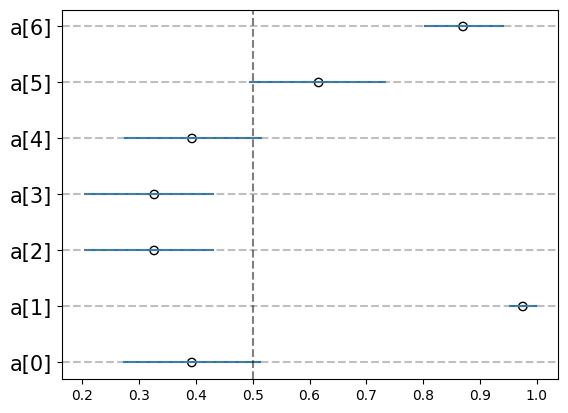

In [19]:
s = {k: inv_logit(v) for k, v in unnest_samples(m11_4.get_samples(group_by_chain=False), False).items() if k[0] == "a"}
_s = {k: v.numpy() for k, v in s.items() if k[0] == "a"}
plot_intervals(_s, 0.89, vline=0.5)

Now let's take a look at the influence of the treatment on the outcome. "L/P" means "prosocial on left/partner", and "R/N" means "prosocial on right/no partner"

Now let’s consider the treatment effects, hopefully estimated more precisely because the
model could subtract out the handedness variation among actors. On the logit scale

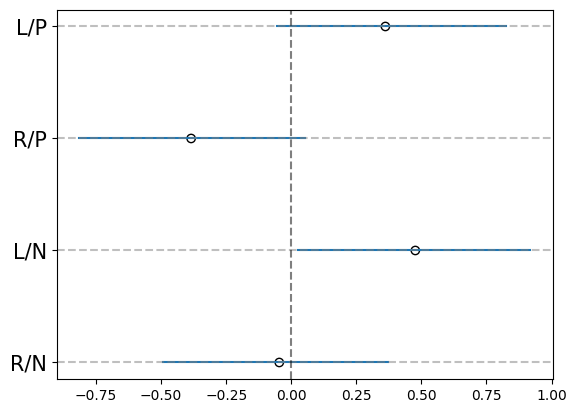

In [20]:
s = {k: v for k, v in unnest_samples(m11_4.get_samples(group_by_chain=False), False).items()}
var_nm = {str(i): k for i, k in enumerate(("R/N", "L/N", "R/P", "L/P"))}
_s = {var_nm[k[-2]]: v.numpy() for k, v in s.items() if k[0] == "b"}
plot_intervals(_s, 0.89)

We note that if we want to figure out whether having a partner affects the prosocial behavior or not, we should probably compare `b[0]` with `b[2]` (prosocial on right) and `b[2]` with `b[3]` (prosocial on left).

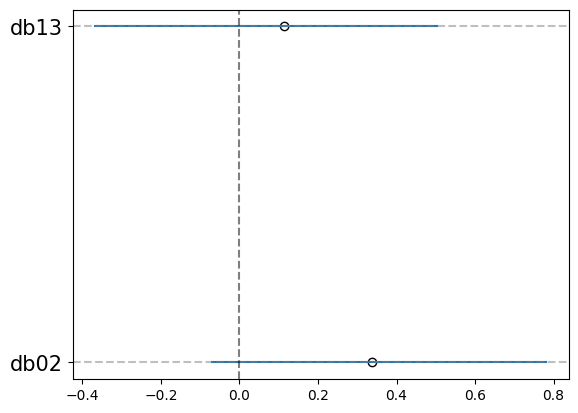

In [21]:
_s = {"db02": (s["b[0]"] - s["b[2]"]).numpy(), "db13": (s["b[1]"] - s["b[3]"]).numpy()}
plot_intervals(_s, 0.89)

We can see that there might be a slight tendency for prosocial behavior if the prosocial option is on the right, but not on the left. I would be very skeptical of this result. It is still consistent with zero. Let's consider a posterior prediction check. First, calculate a matrix which is the proportion of left pulls for each actor in each treatment.

In [22]:
pl = np.empty((d["actor"].nunique(), d["treatment"].nunique()))
for a, group in d.groupby("actor"):
    for t, group in group.groupby("treatment"):
        pl[a, t] = group["pulled_left"].mean()
# Each row is an individual chimpanzee.
# Each column is a treatment.
pl

array([[0.33333333, 0.5       , 0.27777778, 0.55555556],
       [1.        , 1.        , 1.        , 1.        ],
       [0.27777778, 0.61111111, 0.16666667, 0.33333333],
       [0.33333333, 0.5       , 0.11111111, 0.44444444],
       [0.33333333, 0.55555556, 0.27777778, 0.5       ],
       [0.77777778, 0.61111111, 0.55555556, 0.61111111],
       [0.77777778, 0.83333333, 0.94444444, 1.        ]])

Now let's plot this data vs the posterior predictive density.

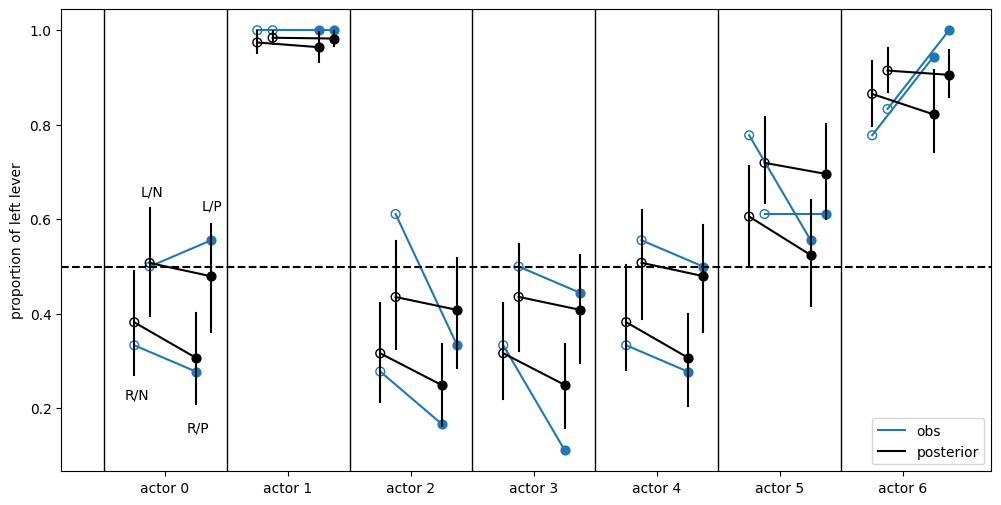

In [23]:
plt.figure(figsize=(12, 6))
# actual data
for a in range(len(pl)):
    for i in (0, 1):
        x = [4*a+0.5*i, 4*a+0.5*i+2]
        y = pl[a, [i, i+2]]
        plt.plot(x, y, color="C0")
        plt.scatter(x[0], y[0], s=40, facecolor="none", edgecolor="C0")
        plt.scatter(x[1], y[1], s=40, color="C0")
    plt.axvline(4*a-1, color="black", linewidth=1)
#plt.show()
# HPDI
for a in range(7):
    for i1, i2 in ((0, 2), (1, 3)):
        p1 = inv_logit(s[f"a[{a}]"] + s[f"b[{i1}]"]).numpy()
        p2 = inv_logit(s[f"a[{a}]"] + s[f"b[{i2}]"]).numpy()
        mu1 = p1.mean()
        mu2 = p2.mean()
        hpdi1 = HPDI(p1, 0.89)
        hpdi2 = HPDI(p2, 0.89)
        x = [4*a+0.5*i1, 4*a+0.5*i1+2]
        y = [mu1, mu2]
        plt.plot(x, y, color="black")
        plt.scatter(x[0], y[0], s=40, facecolor="none", edgecolor="black")
        plt.plot(2*[x[0]], hpdi1, color="black")
        plt.scatter(x[1], y[1], s=40, color="black")
        plt.plot(2*[x[1]], hpdi2, color="black")
plt.axhline(0.5, color="black", linestyle="--")
ticks, labels = zip(*((4*a+1, f"actor {a}") for a in range(7)))
plt.xticks(ticks, labels)
plt.ylabel("proportion of left lever")
plt.plot([],[], color="C0", label="obs")
plt.plot([],[], color="black", label="posterior")
plt.legend()
plt.text(0.2, 0.65, "L/N")
plt.text(2.2, 0.62, "L/P")
plt.text(-0.3, 0.22, "R/N")
plt.text(1.7, 0.15, "R/P")
plt.show()

In [24]:
data = {col: tt(d[col]).long() for col in ("actor", "treatment", "pulled_left")}

# Get log probability from traces
s = m11_4.get_samples()
num_samples = len(s["a"])
num_data_pts = len(data["pulled_left"])
log_p = np.zeros((num_samples, num_data_pts))
for i in range(num_samples):
    _s = {k: v[i] for k, v in s.items()}
    conditioned_model = pyro.condition(model_m11_4, data=_s)
    tr = pyro.poutine.trace(conditioned_model).get_trace(data)
    log_p[i] = tr.nodes["pulled_left"]["fn"].log_prob(data["pulled_left"].double())

pmax = log_p.max(axis=0)
waic = {"m11_4": -2*(pmax + np.log(np.exp(log_p - pmax).mean(axis=0)) - np.var(log_p, axis=0))}

### Code 11.17 - 11.21
There is an interaction effect between taking the prosocial option and a partner being present. We could build a simpler model that doesn't use this interaction and see how it performs.

In [25]:
cols = ["prosoc_left", "condition", "pulled_left", "actor"]
data = format_data(d[cols], categoricals=cols)

def model_m11_5(data, training=False):
    a = pyro.sample("a", Normal(0., 1.5).expand([7]).to_event(1))
    bs = pyro.sample("bs", Normal(0., 0.5).expand([2]).to_event(1))
    bc = pyro.sample("bc", Normal(0., 0.5).expand([2]).to_event(1))
    p = inv_logit(a[data["actor"]] + bs[data["prosoc_left"]] + bc[data["condition"]])
    if training:
        pyro.sample("pulled_left", Bernoulli(p), obs=data["pulled_left"].float())
    else:
        return pyro.sample("pulled_left", Bernoulli(p))

m11_5 = train_nuts(model_m11_5, data, 3000, 3000, 1)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 6000/6000 [00:33, 178.34it/s, step size=2.66e-01, acc. prob=0.916]


In [26]:
m11_5.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.63      0.44     -0.63     -1.31      0.12    813.90      1.00
      a[1]      3.76      0.77      3.73      2.49      5.02   1542.42      1.00
      a[2]     -0.94      0.44     -0.94     -1.66     -0.21    853.21      1.00
      a[3]     -0.94      0.45     -0.93     -1.71     -0.23    844.91      1.00
      a[4]     -0.63      0.44     -0.63     -1.35      0.11    795.74      1.00
      a[5]      0.30      0.45      0.30     -0.47      1.02    878.74      1.00
      a[6]      1.79      0.52      1.79      0.96      2.69   1030.59      1.00
     bc[0]      0.26      0.34      0.26     -0.33      0.76    982.06      1.00
     bc[1]      0.01      0.33      0.01     -0.51      0.59   1027.27      1.00
     bs[0]     -0.19      0.33     -0.19     -0.71      0.38    921.83      1.00
     bs[1]      0.50      0.33      0.50     -0.02      1.06    923.47      1.00

Number of divergences: 0


In [27]:
samples = unnest_samples(m11_5.get_samples(group_by_chain=True), True)

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'bc'}>, <Axes: title={'center': 'bc'}>],
       [<Axes: title={'center': 'bs'}>, <Axes: title={'center': 'bs'}>]],
      dtype=object)

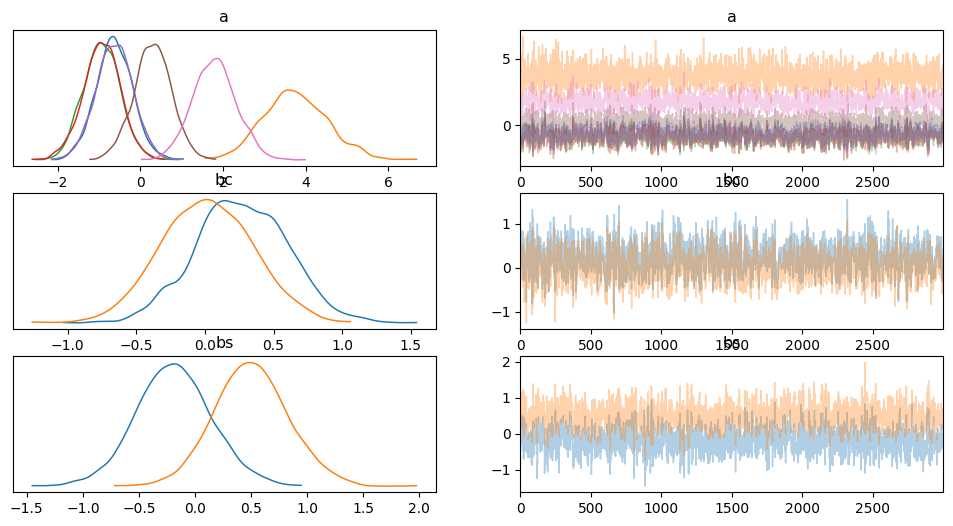

In [28]:
az.plot_trace(az.from_pyro(m11_5))
#traceplot(samples, 1)
#plt.show()

In [29]:
cols = ["prosoc_left", "condition", "pulled_left", "actor"]
data = format_data(d[cols], categoricals=cols)

# Get log probability from traces
s = m11_5.get_samples()
num_samples = len(s["a"])
num_data_pts = len(data["pulled_left"])
log_p = np.zeros((num_samples, num_data_pts))
for i in range(num_samples):
    _s = {k: v[i] for k, v in s.items()}
    conditioned_model = pyro.condition(model_m11_5, data=_s)
    tr = pyro.poutine.trace(conditioned_model).get_trace(data)
    log_p[i] = tr.nodes["pulled_left"]["fn"].log_prob(data["pulled_left"].double())

In [30]:
pmax = log_p.max(axis=0)
waic["m11_5"] = -2*(pmax + np.log(np.exp(log_p - pmax).mean(axis=0) - np.var(log_p, axis=0)))

In [31]:
df = pd.DataFrame({k: {
    "WAIC": w.sum(),
    "SE": np.sqrt(len(w)*w.var()),
} for k, w in waic.items()}).T
best_model = df.iloc[np.argmin(df["WAIC"])].name
df["dWAIC"] = [(waic[k] - waic[best_model]).sum() for k in waic]
df["dSE"] = [np.sqrt(len(waic[k])*(waic[k] - waic[best_model]).var()) for k in waic]
df

,WAIC,SE,dWAIC,dSE
m11_4,532.109000,18.919683,0.000000,0.000000
m11_5,542.811482,20.300430,10.702482,2.161312


It appears the model with the interaction is really no better than the model without it.

## Code 11.22
Let's discuss absolute vs relative changes. On average, switching from no partner to partner reduces the odds of pulling the left lever by 8%. 

In [32]:
s = unnest_samples({"b": m11_4.get_samples()["b"]})
(s["b[3]"] - s["b[1]"]).exp().mean().item()

0.925077077767493

The risk of working with relative effects is that if an effect is really small in absolute terms, a large relative change might not make any difference.

## Code 11.23 - 11.27
Redo the chimpanzee analysis, but this time aggregate all the data and use the binomial distribution rather than the Bernoulli.

In [33]:
chimp_df = pd.read_csv("data/chimpanzees.csv", sep=";")
print("# rows:", len(chimp_df))
chimp_df.sample(5)

# rows: 504


,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
484,7,2.0,1,3,34,0,0,1
208,3,2.0,1,5,58,1,1,1
79,2,NaN,0,2,15,1,1,1
184,3,8.0,1,1,10,1,0,0
129,2,2.0,1,4,42,0,0,1


In [34]:
print("# actors:", chimp_df["actor"].nunique())

# actors: 7


Aggregate (sum) the number of left pulls rather than treat each data point individually

In [35]:
d = chimp_df.copy()
d["treatment"] = d["prosoc_left"] + 2*d["condition"]
d["actor"] -= 1
cols = ["treatment", "actor", "prosoc_left", "condition"]
dagg = (
    d.groupby(cols)
    ["pulled_left"].sum()
    .reset_index()
    .rename(columns={"pulled_left": "left_pulls", "prosoc_left": "side", "condition": "cond"})
)
dagg.sample(5)

,treatment,actor,side,cond,left_pulls
13,1,6,1,0,15
25,3,4,1,1,9
6,0,6,0,0,14
4,0,4,0,0,6
14,2,0,0,1,5


In [36]:
dagg.sample(5)

,treatment,actor,side,cond,left_pulls
27,3,6,1,1,18
23,3,2,1,1,6
24,3,3,1,1,8
11,1,4,1,0,10
20,2,6,0,1,17


In [37]:
num_actors = dagg["actor"].nunique()
num_treatments = dagg["treatment"].nunique()

data = format_data(dagg, categoricals=set(dagg.columns) - set(["left_pulls"]))

def model_m11_6(data, training=False):
    a = pyro.sample("a", Normal(0., 1.5).expand([num_actors]).to_event(0))
    b = pyro.sample("b", Normal(0., 0.5).expand([num_treatments]).to_event(0))
    actor, treatment = data["actor"], data["treatment"]
    p = inv_logit(a[actor] + b[treatment])
    if training:
        pyro.sample("left_pulls", Binomial(18, p), obs=data["left_pulls"])
    else:
        return pyro.sample("left_pulls", Binomial(18, p))

m11_6 = train_nuts(model_m11_6, data, 3000, 6000, 1)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 9000/9000 [00:24, 362.60it/s, step size=4.29e-01, acc. prob=0.901]


Let's compare the posterior distributions with those of model 11.4 (the one without explicit interactions):

In [38]:
m11_6.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.44      0.33     -0.44     -0.98      0.11   1735.30      1.00
      a[1]      3.89      0.75      3.84      2.72      5.16   5272.16      1.00
      a[2]     -0.74      0.34     -0.75     -1.29     -0.19   1736.61      1.00
      a[3]     -0.75      0.34     -0.74     -1.27     -0.17   1790.80      1.00
      a[4]     -0.45      0.33     -0.45     -0.96      0.14   1888.54      1.00
      a[5]      0.49      0.34      0.49     -0.08      1.02   1848.32      1.00
      a[6]      1.96      0.42      1.95      1.25      2.63   2452.25      1.00
      b[0]     -0.04      0.29     -0.05     -0.51      0.44   1517.43      1.00
      b[1]      0.47      0.29      0.47     -0.02      0.94   1556.45      1.00
      b[2]     -0.39      0.29     -0.38     -0.86      0.08   1580.14      1.00
      b[3]      0.36      0.29      0.36     -0.07      0.88   1538.74      1.00

Number of divergences: 0


In [39]:
m11_4.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.45      0.33     -0.45     -0.98      0.07   1068.16      1.00
      a[1]      3.90      0.74      3.85      2.73      5.05   2355.35      1.00
      a[2]     -0.74      0.33     -0.74     -1.26     -0.17   1035.16      1.00
      a[3]     -0.74      0.33     -0.74     -1.31     -0.22   1111.24      1.00
      a[4]     -0.44      0.32     -0.45     -0.94      0.11   1007.37      1.00
      a[5]      0.48      0.32      0.49     -0.05      1.01   1060.35      1.00
      a[6]      1.96      0.41      1.95      1.33      2.64   1410.38      1.00
      b[0]     -0.05      0.28     -0.05     -0.49      0.39    837.54      1.00
      b[1]      0.48      0.28      0.47      0.03      0.95    974.20      1.00
      b[2]     -0.38      0.27     -0.38     -0.82      0.07    910.73      1.00
      b[3]      0.36      0.27      0.36     -0.08      0.83    920.98      1.00

Number of divergences: 0


They are effectively identitcal! Let's take a look at the WAIC for this model though:

In [40]:
# Get log probability from traces
s = m11_6.get_samples()
num_samples = len(s["a"])
num_data_pts = len(data["left_pulls"])
log_p = np.zeros((num_samples, num_data_pts))
for i in range(num_samples):
    _s = {k: v[i] for k, v in s.items()}
    conditioned_model = pyro.condition(model_m11_6, data=_s)
    tr = pyro.poutine.trace(conditioned_model).get_trace(data)
    log_p[i] = tr.nodes["left_pulls"]["fn"].log_prob(data["left_pulls"].double())

In [41]:
pmax = log_p.max(axis=0)
waic["m11_6"] = -2*(pmax + np.log(np.exp(log_p - pmax).mean(axis=0)) - np.var(log_p, axis=0))

In [42]:
{k: v.sum() for k, v in waic.items()}

{'m11_4': 532.109000481903,
 'm11_5': 542.8114821074114,
 'm11_6': 113.07133024391457}

Model 11.6's WAIC is very different from the other two. And that makes sense, because 1) the number of data points has changed 2) the likelihood function has changed. It is no wonder they are so different. The comparison is not valid.

In [43]:
N=9
H=6
p=0.2
# deviance of aggregated 6-in-9
binomial_deviance = -2*Binomial(N, p).log_prob(tt([H])).item()
# deviance of dis-aggregated
H = tt([1.,1.,1.,1.,1.,1.,0.,0.,0.])
bernoulli_deviance = -2*torch.sum(Bernoulli(p).log_prob(H)).item()

print(round(binomial_deviance, 2))
print(round(bernoulli_deviance, 2))

11.79
20.65


### Code 11.28 - 11.34
In the previous example, every observation had 18 trials. What if there are different numbers of trials? Let's look at a famous problem that, on the face of things, appears to show that UC Berkeley admissions are biased against females.

In [44]:
ucb_df = pd.read_csv("data/UCBadmit.csv", sep=";")
ucb_df

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


If we only use the gender as a predictor, then this is what we get:

In [45]:
data = {
    "gender": tt(ucb_df["applicant.gender"].map({"male":0, "female":1}).values).long(),
    "admit": tt(ucb_df["admit"].values).double(),
    "applications": tt(ucb_df["applications"].values).long(),
}

def model_m11_7(data, training=False):
    a = pyro.sample("a", Normal(0., 1.5).expand([2]).to_event(0))
    p = inv_logit(a[data["gender"]])
    if training:
        pyro.sample("admit", Binomial(data["applications"], p), obs=data["admit"])
    else:
        return pyro.sample("admit", Binomial(data["applications"], p))
    
m11_7 = train_nuts(model_m11_7, data, 1000, 3000, 1)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 4000/4000 [00:05, 756.37it/s, step size=7.67e-01, acc. prob=0.935]


In [46]:
m11_7.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.22      0.04     -0.22     -0.29     -0.16   1982.09      1.00
      a[1]     -0.83      0.05     -0.83     -0.91     -0.75   2483.91      1.00

Number of divergences: 0


In [47]:
# Copute the contrast
# 
s = unnest_samples(m11_7.get_samples())
_s = {
    "diff_a": (s["a[0]"] - s["a[1]"]).numpy(),
    "diff_p": (inv_logit(s["a[0]"]) - inv_logit(s["a[1]"])).numpy(),
}
precis(_s)

,mean,stddev,5.5%,94.5%
diff_a,0.610861,0.063623,0.507902,0.71285
diff_p,0.14166,0.014314,0.118283,0.164222


It certainly seems that male applicants have a much higher probability of being admitted than female students. They have roughly a 12-16% higher admission rate across all departments. Does that mean the school's admissions are biased? Let's examine the posterior predictions and how they compare with the data.

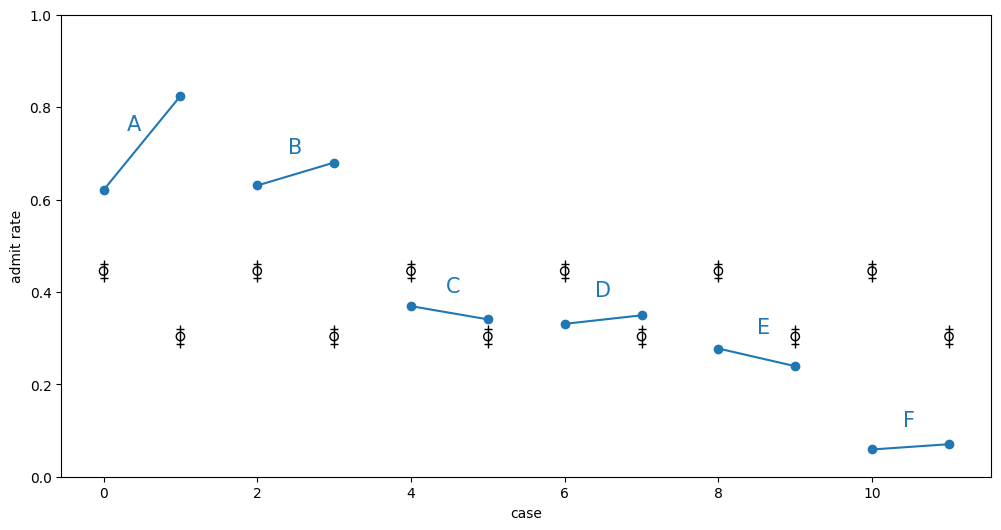

In [48]:
fig = plt.figure(figsize=(12, 6))
# Get posterior distribution of p
s = m11_7.get_samples()
p = inv_logit(s["a"][:,data["gender"]])
# calculate mean/HPDI for each data point
p_mean = p.mean(dim=0)
p_hpdi = hpdi(p, 0.89, dim=0)
# plot distribution summaries
x = torch.arange(p.shape[-1])
plt.scatter(x, p_hpdi[0], color="black", marker="+", linewidth=1)
plt.scatter(x, p_hpdi[1], color="black", marker="+", linewidth=1)
plt.scatter(x, p_mean, color="black", facecolor="none", edgecolor="black", linewidth=1)
plt.scatter(x, p_mean, color="black", marker="|", linewidth=1)
# plot data points
y = data["admit"]/data["applications"]
plt.scatter(x, y, color="C0", zorder=0)
for i in range(len(x)//2):
    idx = slice(2*i, 2*i+2)
    plt.plot(x[idx], y[idx], color="C0", zorder=0)
for x, y, label in (
    (0.3, 0.75, "A"),
    (2.4, 0.70, "B"),
    (4.45, 0.4, "C"),
    (6.4, 0.39, "D"),
    (8.5, 0.31, "E"),
    (10.4, 0.11, "F"),
):
    plt.text(x, y, label, color="C0", fontsize=15)
plt.ylim(top=1, bottom=0)
plt.xlabel("case")
plt.ylabel("admit rate")
plt.show()

We observe two things: 1) our model's prediction is terrible, 2) the assumption that admission probability only depends on gender is probably not correct. It appears that departments like A and B have high admittance, while F has very low admittance. Perhaps the difference in admission rates across departments is due to females applying more often to departments with low admit rates? Let us add the department as a predictor to the model.

In [49]:
data = {
    "gender": tt(ucb_df["applicant.gender"].map({"male":0, "female":1}).values).long(),
    "dept": tt(ucb_df["dept"].map({c: i for c, i in zip("ABCDEF", range(6))}).values).long(),
    "admit": tt(ucb_df["admit"].values).double(),
    "applications": tt(ucb_df["applications"].values).long(),
}

def model_m11_8(data, training=False):
    a = pyro.sample("a", Normal(0., 1.5).expand([2]).to_event(0))
    d = pyro.sample("d", Normal(0., 1.5).expand([6]).to_event(0))
    p = inv_logit(a[data["gender"]] + d[data["dept"]])
    if training:
        pyro.sample("admit", Binomial(data["applications"], p), obs=data["admit"])
    else:
        return pyro.sample("admit", Binomial(data["applications"], p))
    
m11_8 = train_nuts(model_m11_8, data, 1000, 3000, 1)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 4000/4000 [00:30, 132.73it/s, step size=6.84e-02, acc. prob=0.906]


In [50]:
m11_8.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.54      0.55     -0.54     -1.49      0.31    218.76      1.00
      a[1]     -0.44      0.55     -0.44     -1.42      0.38    221.05      1.00
      d[0]      1.12      0.55      1.12      0.24      2.05    220.92      1.00
      d[1]      1.08      0.55      1.07      0.13      1.94    221.73      1.00
      d[2]     -0.14      0.55     -0.14     -1.00      0.81    220.42      1.00
      d[3]     -0.17      0.55     -0.17     -1.02      0.78    221.57      1.00
      d[4]     -0.61      0.55     -0.62     -1.49      0.34    227.11      1.00
      d[5]     -2.17      0.56     -2.17     -3.05     -1.24    226.37      1.00

Number of divergences: 0


In [51]:
s = unnest_samples(m11_8.get_samples())
_s = {
    "diff_a": (s["a[0]"] - s["a[1]"]).numpy(),
    "diff_p": (inv_logit(s["a[0]"]) - inv_logit(s["a[1]"])).numpy(),
}
precis(_s)

,mean,stddev,5.5%,94.5%
diff_a,-0.097571,0.079311,-0.225067,0.026987
diff_p,-0.021734,0.018113,-0.051358,0.005866


Now the difference that gender makes appears much smaller, and even appears as though the admissions process is mildly biased against males now! Although the posterior is still very much consistent with no difference between the genders.

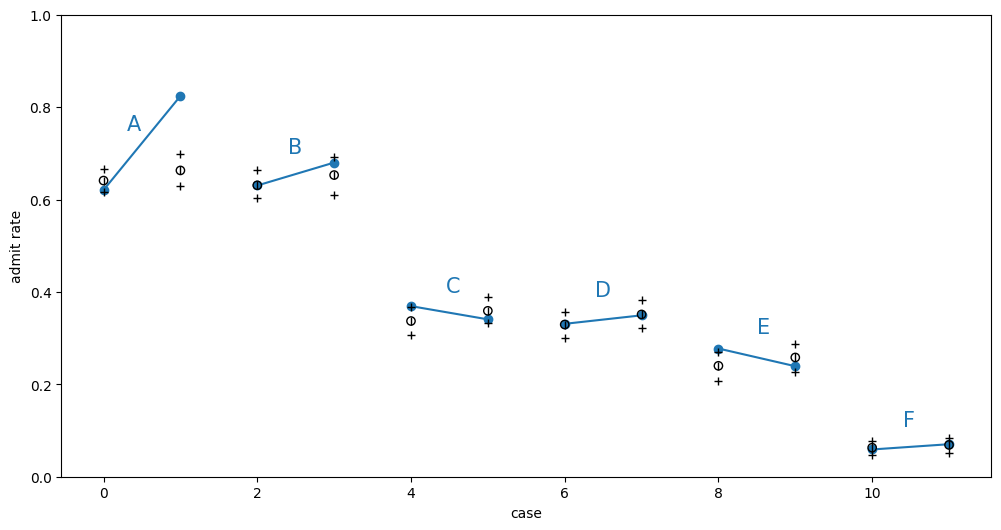

In [52]:
fig = plt.figure(figsize=(12, 6))
# Get posterior distribution of p
s = m11_8.get_samples()
p = inv_logit(s["a"][:,data["gender"]] + s["d"][:,data["dept"]])
# calculate mean/HPDI for each data point
p_mean = p.mean(dim=0)
p_hpdi = hpdi(p, 0.89, dim=0)
# plot distribution summaries
x = torch.arange(p.shape[-1])
plt.scatter(x, p_hpdi[0], color="black", marker="+", linewidth=1)
plt.scatter(x, p_hpdi[1], color="black", marker="+", linewidth=1)
plt.scatter(x, p_mean, color="black", facecolor="none", edgecolor="black", linewidth=1)
plt.scatter(x, p_mean, color="black", marker="|", linewidth=1)
# plot data points
y = data["admit"]/data["applications"]
plt.scatter(x, y, color="C0", zorder=0)
for i in range(len(x)//2):
    idx = slice(2*i, 2*i+2)
    plt.plot(x[idx], y[idx], color="C0", zorder=0)
for x, y, label in (
    (0.3, 0.75, "A"),
    (2.4, 0.70, "B"),
    (4.45, 0.4, "C"),
    (6.4, 0.39, "D"),
    (8.5, 0.31, "E"),
    (10.4, 0.11, "F"),
):
    plt.text(x, y, label, color="C0", fontsize=15)
plt.ylim(top=1, bottom=0)
plt.xlabel("case")
plt.ylabel("admit rate")
plt.show()

Let's look at the fraction of total applicants to each department by gender. We can see that females preferentially applied to departments with lower overall admittance rates. Department B in particular saw almost no female applicants but had a relatively higher rate of admission.

In [53]:
df = ucb_df.pivot(index="applicant.gender", columns="dept", values="applications")
df = df/(df.loc["male"] + df.loc["female"])
df.round(2)

dept,A,B,C,D,E,F
applicant.gender,,,,,,
female,0.12,0.04,0.65,0.47,0.67,0.48
male,0.88,0.96,0.35,0.53,0.33,0.52


The explanation here from a causality standpoint is that gender ($G$) influences both department ($D$) and admittance ($A$), while department only influences admittance ($A$). When trying to estimate the influence of $G$ on $A$, there is a backdoor through $D$ that confounds the inference. By conditioning on $D$, we can more accurately ascertain the influence of $G$.

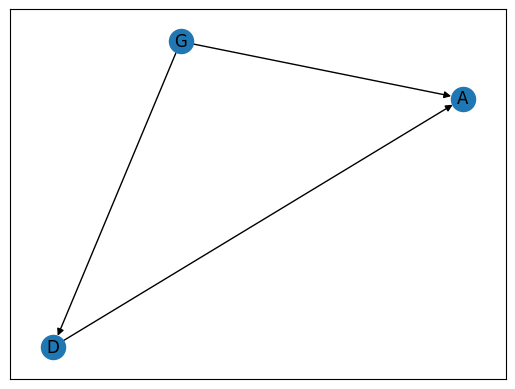

In [54]:
G = nx.DiGraph((("G", "D"), ("D", "A"), ("G", "A")))
nx.draw_networkx(G)
plt.show()

### Code 11.36 - 11.54
Now we will start looking at the Poisson distribution $\text{Poisson}(\lambda)$. This distribution is a special limit of the binomial distribution $\text{Binomial}(n, p)$ where the product $np = \lambda$ stays fixed, but $n \rightarrow \infty$ and $p \rightarrow 0$. It is simpler in the sense that there is one less parameter, and is natural if you know the average of some count process, but not the upper limit. We will investigate this in the context of a dataset of tool creation by Oceanic societies.

In [55]:
kline_df = pd.read_csv("data/Kline.csv", sep=";")
print("# rows:", len(kline_df))
kline_df

# rows: 10


,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


There are three ideas that we will explore.
1. The number of tools increases with the log of the population size
2. The number of tools increases with the level of contact among islands
3. There is an interaction effect between population and contact (assumed positive)
This coresponds to the model
$$
T_i \sim \text{Poisson}(\lambda_i) \\
\lambda = \exp(\alpha_{\text{CID}[i]} + \beta_{\text{CID}[i]} \log P_i)
$$
where CID = contact ID, and we have yet to determine the priors for $\alpha$ and $\beta$

So what kind of priors should we use? Let's consider $\alpha$ by itself at first. Should we use some kind of vague prior like $\text{Normal}(0, 10)$? Even though it is sharply peaked at 0, this actually results in a ridiculously large number of tools on average because the tail is so heavy; the mean of a log-normal distribution is $\exp(\mu + \sigma^2/2)$ which evaluates to $\exp(50) \sim 10^{21}$...

In [56]:
# mean of log-nomral is exp(mu + sigma^2/2)
mu = tt(0)
sigma = tt(10)
np.exp(50), torch.exp(mu + (sigma*sigma)/2)

(5.184705528587073e+21, tensor(5.1847e+21))

In [57]:
a = Normal(0,10).sample([10000])
lambda1 = torch.exp(a)
# absurdly high mean
print(torch.mean(lambda1))

tensor(4.6477e+11)


In [58]:
# mean of log-nomral is exp(mu + sigma^2/2)
mu = tt(3)
sigma = tt(0.5)
torch.exp(mu + (sigma*sigma)/2)

tensor(22.7599)

In [59]:
a = Normal(3, 0.5).sample([10000])
lambda1 = torch.exp(a)
# reasonable prior
print(torch.mean(lambda1))

tensor(22.8484)


What about a more reasonable prior, like $\text{Normal}(3, 0.5)$? This has a mean of around $\exp(3 + 0.5^2/2) \approx 20$.

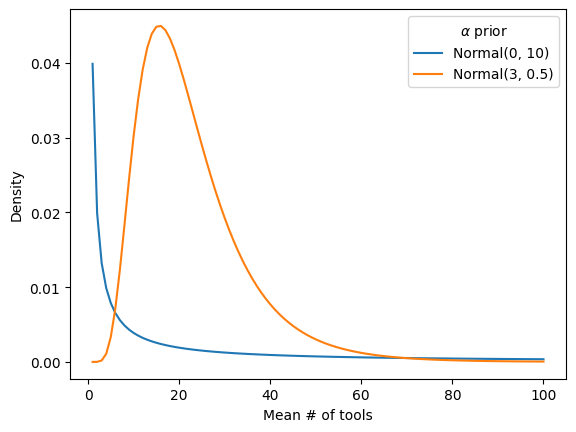

In [60]:
x = torch.linspace(1, 100, steps=100)
plt.plot(x, LogNormal(0, 10).log_prob(x).exp(), label="Normal(0, 10)")
plt.plot(x, LogNormal(3, 0.5).log_prob(x).exp(), label="Normal(3, 0.5)")
plt.legend(title=r"$\alpha$ prior")
plt.xlabel("Mean # of tools")
plt.ylabel("Density")
plt.show()

Now what about $\beta$? Let us consider the same initial prior of $\text{Normal}(0, 10)$ and sample some curves of $\lambda$ as a function of (log) population.

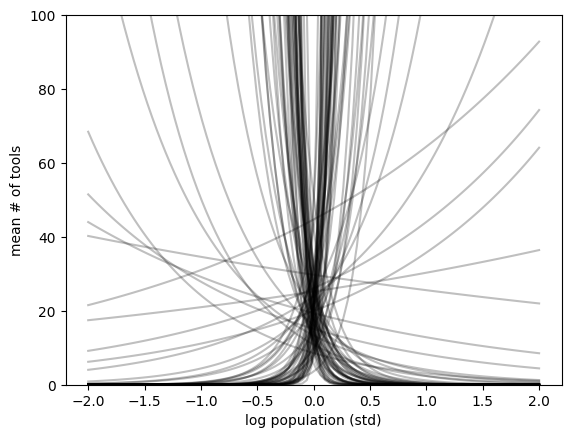

In [61]:
N = 100

a = Normal(3, 0.5).sample([N])
b = Normal(0, 10).sample([N])

x = torch.linspace(-2, 2, steps=100)

for i in range(N):
    y = (a[i] + b[i]*x).exp()
    plt.plot(x, y, color="black", alpha=0.25)
plt.ylim(bottom=0, top=100)
plt.xlabel("log population (std)")
plt.ylabel("mean # of tools")
plt.show()

That honestly seems kind of ridiculous. A large number of these models explode when the population is close to the mean, far exceeding the maximum value in the dataset, and die out when further away. It does seem to be ambivalent to whether tool use increases or decreases with population, which is good since we don't want to assume a positive or negative correlation from the get-go. Let's use a prior that has a smaller standard deviation, like $\text{Normal}(0, 0.2)$:

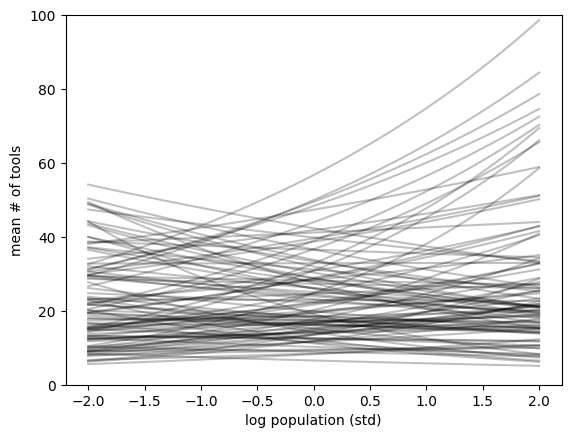

In [62]:
N = 100

a = Normal(3, 0.5).sample([N])
b = Normal(0, 0.2).sample([N])

x = torch.linspace(-2, 2, steps=100)
for i in range(N):
    y = (a[i] + b[i]*x).exp()
    plt.plot(x, y, color="black", alpha=0.25)
plt.ylim(bottom=0, top=100)
plt.xlabel("log population (std)")
plt.ylabel("mean # of tools")
plt.show()

Alright, looks reasonable. Now let's learn some models. We'll learn both an intercept-only model (m11.9), and a full interaction model (m11.10).

In [63]:
df = kline_df.copy()
df["log_pop"] = np.log(df["population"])
df["P"] = (df.log_pop - df.log_pop.mean())/df.log_pop.std()
df["contact_id"] = df["contact"].map({"low": 0, "high": 1}).values
data = format_data(df[["P", "contact_id", "total_tools"]], categoricals=("contact_id",))

In [64]:
def model_m11_9(data, training=False):
    a = pyro.sample("a", Normal(3., 0.5).expand([2]).to_event(1))
    lambduh = torch.exp(a)[...,data["contact_id"]]
    with pyro.plate("obs", dim=-1):
        pyro.sample("T", Poisson(lambduh), obs=data["total_tools"])
    
m11_9 = train_nuts(model_m11_9, data, 1000, 2000, 1)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 3000/3000 [00:03, 900.88it/s, step size=7.92e-01, acc. prob=0.924] 


In [65]:
def model_m11_10(data, training=False):
    a = pyro.sample("a", Normal(3., 0.5).expand([2]).to_event(1))
    b = pyro.sample("b", Normal(0., 0.2).expand([2]).to_event(1))
    # print(a.shape, b.shape)
    cid = data["contact_id"]
    lambduh = torch.exp(a[..., cid] + (b[..., cid]*data["P"]))
    with pyro.plate("obs", dim=-1):
        pyro.sample("T", Poisson(lambduh), obs=data["total_tools"])
    
m11_10 = train_nuts(model_m11_10, data, 1000, 2000, 1)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 3000/3000 [00:05, 571.92it/s, step size=7.57e-01, acc. prob=0.889]


In [66]:
def compare_waic(models: dict, samples: dict, data):
    waic = dict()
    for model_nm in models:
        # Get log probability from traces
        s = samples[model_nm]
        num_samples = len(list(s.values())[0])
        num_data_pts = len(data["total_tools"])
        log_p = np.zeros((num_samples, num_data_pts))
        for i in range(num_samples):
            _s = {k: v[i] for k, v in s.items()}
            conditioned_model = pyro.condition(models[model_nm], data=_s)
            tr = pyro.poutine.trace(conditioned_model).get_trace(data)
            log_p[i] = tr.nodes["T"]["fn"].log_prob(data["total_tools"].double())
        pmax = log_p.max(axis=0)
        waic[model_nm] = -2*(pmax + np.log(np.exp(log_p - pmax).mean(axis=0)) - np.var(log_p, axis=0))
    df = pd.DataFrame({k: {
        "WAIC": w.sum(),
        "SE": np.sqrt(len(w)*w.var()),
    } for k, w in waic.items()}).T
    best_model = df.iloc[np.argmin(df["WAIC"])].name
    df["dWAIC"] = [(waic[k] - waic[best_model]).sum() for k in waic]
    df["dSE"] = [np.sqrt(len(waic[k])*(waic[k] - waic[best_model]).var()) for k in waic]
    return waic, df

In [67]:
models = {"m11.9": model_m11_9, "m11.10": model_m11_10}
samples = {"m11.9": m11_9.get_samples(), "m11.10": m11_10.get_samples()}
waic, waic_df = compare_waic(models, samples, data)
waic_df

,WAIC,SE,dWAIC,dSE
m11.9,150.860240,46.010438,67.055455,45.187584
m11.10,83.804785,12.307779,0.000000,0.000000


Looks like the model with the interaction effect has better predictive ability; no surprise. Let's plot the posterior predictions against the data for comparison

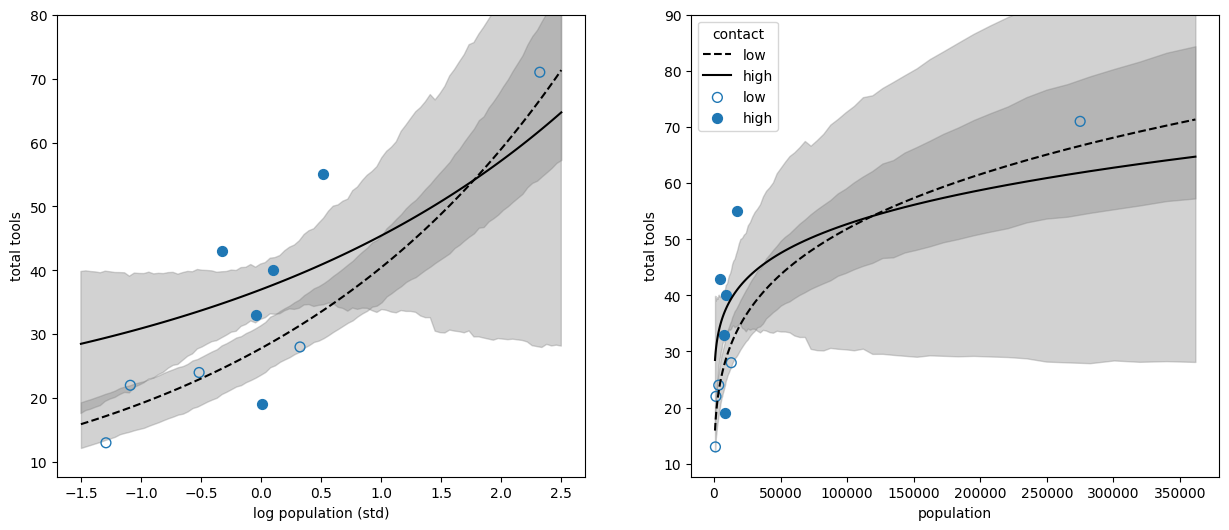

In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
# Get mean and HPDI for regression lines
cid = df["contact_id"] == 0
pop_std = torch.linspace(-1.5, 2.5, steps=100)
pop = torch.exp(df.log_pop.std()*pop_std + df.log_pop.mean())
s = m11_10.get_samples()
lambduh = torch.exp(s["a"][...,None] + s["b"][...,None] * pop_std[None,None,:])
lam_mean = lambduh.mean(dim=0)
lam_hpdi = hpdi(lambduh, 0.89, dim=0)
# Log scale
plt.sca(axes[0])
# Plot the lines/intervals
plt.plot(pop_std, lam_mean[0], color="black", linestyle="--", label="low")
plt.plot(pop_std, lam_mean[1], color="black", linestyle="-", label="high")
plt.fill_between(pop_std, *lam_hpdi[:,0,:], color="gray", alpha=0.35)
plt.fill_between(pop_std, *lam_hpdi[:,1,:], color="gray", alpha=0.35)
# Data
plt.scatter(df[cid]["P"], df[cid]["total_tools"], facecolor="none", edgecolor="C0", s=50)
plt.scatter(df[~cid]["P"], df[~cid]["total_tools"], color="C0", s=50)
plt.xlabel("log population (std)")
plt.ylabel("total tools")
plt.ylim(top=80)
# Linear scale
plt.sca(axes[1])
# Plot the lines/intervals
plt.plot(pop, lam_mean[0], color="black", linestyle="--", label="low")
plt.plot(pop, lam_mean[1], color="black", linestyle="-", label="high")
plt.fill_between(pop, *lam_hpdi[:,0,:], color="gray", alpha=0.35)
plt.fill_between(pop, *lam_hpdi[:,1,:], color="gray", alpha=0.35)
# Data
plt.scatter(df[cid]["population"], df[cid]["total_tools"], facecolor="none", edgecolor="C0", s=50, label="low")
plt.scatter(df[~cid]["population"], df[~cid]["total_tools"], color="C0", s=50, label="high")
plt.legend(title="contact", loc="upper left")
plt.xlabel("population")
plt.ylabel("total tools")
plt.ylim(top=90)
plt.show()

Let's look at which data points were the most influential; I'll use the `arviz` package to evaluate the PSIS-LOO from the posterior (and I probably should have been using it to evaluate the WAIC too...).

In [69]:
loo = az.loo(m11_10, pointwise=True, scale="deviance")

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [70]:
pareto_k = loo.pareto_k.values
idx = pareto_k.argsort()[-4:][::-1]
df.iloc[idx].assign(pareto_k=pareto_k[idx])

,culture,population,contact,total_tools,mean_TU,log_pop,P,contact_id,pareto_k
9,Hawaii,275000,low,71,6.6,12.524526,2.321008,0,0.779097
8,Tonga,17500,high,55,5.4,9.769956,0.518798,1,0.725705
3,Yap,4791,high,43,5.0,8.474494,-0.328773,1,0.522488
1,Tikopia,1500,low,22,4.7,7.313220,-1.088551,0,0.519824


Looks like Hawaii is very influential. That is not surprising, as it almost completely determines the upward inflection of the regression line for low-contact societies in the left plot. Without it, the regression would probably be more linear, and with higher uncertainty.

One downside of this regression is that the intercept in the link function is a free parameter, so we have no guarantee that the number of tools will go to zero as the population goes to zero. This has to be true since there is no one around to make tools in the first place. There is a more concrete theoretical model in which we assume that tools are developed over time rather than created all at once, and they can be added or removed as time goes on. The simplest model assumes the innovation is proportional to population size with some diminishing returns, and that tool loss is proportional to the number of tools, with no diminishing returns.

This leads to a model where the change of number of tools at one time-step is given by
$$ \Delta T = \alpha P^\beta - \gamma T,$$
At equilibrium, when $\Delta T = 0$, this means that
$$\hat{T} = \alpha P^\beta /\gamma$$

So now our GLM looks like
$$
T_i \sim \text{Poisson}(\lambda_i) \\
\lambda_i = \alpha P^\beta/\gamma
$$
Note that there is no link function now!

In [71]:
data = format_data(df[["contact_id","population","total_tools"]], categoricals=("contact_id",))

def model_m11_11(data, training=True):
    """
    There are a number of weird things about this model that I don't like:
    1) I would expect these priors to be much tighter, especially for beta. It should be
        really small because P is like 3 orders of magnitude larger than T
    2) related to point (1) is the fact that using the raw population values are so large, it
        is probably numerically unstable to use them. It might be better to log-transform
        the population and predict it in this space
    3) since both a and g are free parameters, the ratio a/g can be determined, but not a and g
        separately
    """
    a = pyro.sample("a", Normal(1., 1.).expand([2]).to_event(0))
    b = pyro.sample("b", Exponential(1.).expand([2]).to_event(0))
    g = pyro.sample("g", Exponential(1.))
    cid = data["contact_id"]
    P = data["population"]
    lambduh = torch.exp(a[...,cid])*(P**b[...,cid])/g
    with pyro.plate("obs", dim=-1):
        pyro.sample("T", Poisson(lambduh), obs=data["total_tools"])
        
m11_11 = train_nuts(model_m11_11, data, 1000, 2000, 1)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 3000/3000 [01:01, 48.84it/s, step size=6.37e-02, acc. prob=0.881]


In [72]:
m11_11.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      0.93      0.71      0.97     -0.31      1.99    600.82      1.00
      a[1]      0.93      0.88      0.95     -0.60      2.32    869.90      1.00
      b[0]      0.26      0.03      0.26      0.20      0.31   1134.21      1.00
      b[1]      0.29      0.10      0.29      0.13      0.47    691.71      1.00
         g      1.20      0.84      0.99      0.14      2.37    762.53      1.00

Number of divergences: 0


I don't really like some of the design choices McElreath made in the previous model, so I've tried to fix them a bit below. Note that the sampling takes half the time now.

In [73]:
data = format_data(df[["contact_id","log_pop","total_tools"]], categoricals=("contact_id",))

def model_m11_11_1(data, training=True):
    ag = pyro.sample("a/g", Normal(1., 1.).expand([2]).to_event(0))
    b = pyro.sample("b", Exponential(0.5).expand([2]).to_event(0))
    cid = data["contact_id"]
    P = data["log_pop"]
    lambduh = torch.exp(ag[...,cid] + b[...,cid]*P)
    with pyro.plate("obs", dim=-1):
        pyro.sample("T", Poisson(lambduh), obs=data["total_tools"])
        
m11_11_1 = train_nuts(model_m11_11_1, data, 1000, 2000, 1)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 3000/3000 [00:41, 71.84it/s, step size=5.43e-02, acc. prob=0.945]


In [74]:
m11_11_1.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    a/g[0]      0.95      0.36      0.97      0.41      1.57    607.67      1.01
    a/g[1]      0.95      0.84      0.95     -0.34      2.35    520.74      1.00
      b[0]      0.26      0.03      0.26      0.20      0.32    602.05      1.01
      b[1]      0.30      0.09      0.30      0.14      0.43    518.28      1.00

Number of divergences: 0


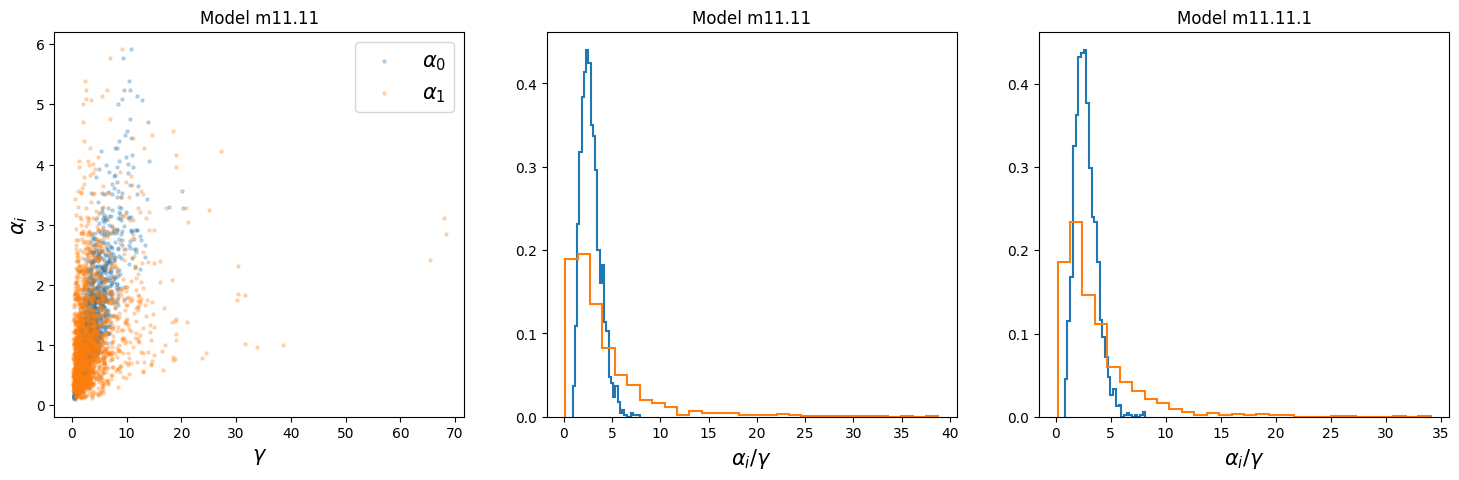

In [75]:
s1 = unnest_samples(m11_11.get_samples())
s2 = unnest_samples(m11_11_1.get_samples())
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))
# correlation plot of alpha and gamma from the first model
plt.sca(axes[0])
plt.scatter(s1["a[0]"].exp(), s1["g"], s=5, alpha=0.25, label=r"$\alpha_0$")
plt.scatter(s1["a[1]"].exp(), s1["g"], s=5, alpha=0.25, label=r"$\alpha_1$")
plt.legend(fontsize=15)
plt.xlabel(r"$\gamma$", fontsize=15)
plt.ylabel(r"$\alpha_i$", fontsize=15)
plt.title("Model m11.11")
# histogram of alpha/gamma from first model
plt.sca(axes[1])
plt.hist(s1["a[0]"].exp()/s1["g"], bins=30, histtype="step", linewidth=1.5, density=True, label=r"$\alpha_0/\gamma$")
plt.hist(s1["a[1]"].exp()/s1["g"], bins=30, histtype="step", linewidth=1.5, density=True, label=r"$\alpha_1/\gamma$")
plt.xlabel(r"$\alpha_i/\gamma$", fontsize=15)
plt.title("Model m11.11")
# plt.xlim(left=-5, right=+5)
# histogram of alpha/gamma from second model
plt.sca(axes[2])
plt.hist(s2["a/g[0]"].exp(), bins=30, histtype="step", linewidth=1.5, density=True, label=r"$\alpha_0/\gamma$")
plt.hist(s2["a/g[1]"].exp(), bins=30, histtype="step", linewidth=1.5, density=True, label=r"$\alpha_1/\gamma$")
plt.xlabel(r"$\alpha_i/\gamma$", fontsize=15)
plt.title("Model m11.11.1")
plt.show()

Notice that there is a fairly high degree of correlation between the $\alpha_i$ and $\gamma$ in the first model, but there is almost no difference between the posterior distributions for $\alpha/\gamma$ (I'm willing to bet that the small difference that does exist is due to the difference in priors since $\gamma$ is no longer in the model).

If we examine the posterior distribution, we can see that $\lambda$ does indeed go to zero as the population goes to zero as well.

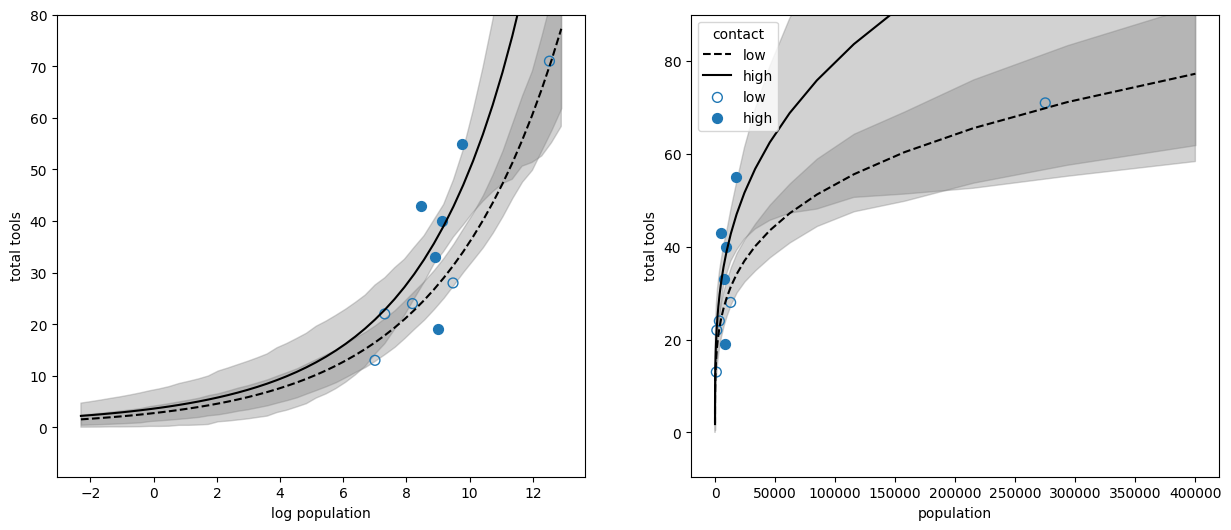

In [76]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
# Get mean and HPDI for regression lines
cid = df["contact_id"] == 0
pop = tt(np.geomspace(0.1, 400000))
log_pop = pop.log()
s = m11_11_1.get_samples()
lambduh = torch.exp(s["a/g"][...,None] + s["b"][...,None] * log_pop[None,None,:])
lam_mean = lambduh.mean(dim=0)
lam_hpdi = hpdi(lambduh, 0.89, dim=0)
# Log scale
plt.sca(axes[0])
# Plot the lines/intervals
plt.plot(log_pop, lam_mean[0], color="black", linestyle="--", label="low")
plt.plot(log_pop, lam_mean[1], color="black", linestyle="-", label="high")
plt.fill_between(log_pop, *lam_hpdi[:,0,:], color="gray", alpha=0.35)
plt.fill_between(log_pop, *lam_hpdi[:,1,:], color="gray", alpha=0.35)
# Data
plt.scatter(df[cid]["log_pop"], df[cid]["total_tools"], facecolor="none", edgecolor="C0", s=50)
plt.scatter(df[~cid]["log_pop"], df[~cid]["total_tools"], color="C0", s=50)
plt.xlabel("log population")
plt.ylabel("total tools")
plt.ylim(top=80)
# Linear scale
plt.sca(axes[1])
# Plot the lines/intervals
plt.plot(pop, lam_mean[0], color="black", linestyle="--", label="low")
plt.plot(pop, lam_mean[1], color="black", linestyle="-", label="high")
plt.fill_between(pop, *lam_hpdi[:,0,:], color="gray", alpha=0.35)
plt.fill_between(pop, *lam_hpdi[:,1,:], color="gray", alpha=0.35)
# Data
plt.scatter(df[cid]["population"], df[cid]["total_tools"], facecolor="none", edgecolor="C0", s=50, label="low")
plt.scatter(df[~cid]["population"], df[~cid]["total_tools"], color="C0", s=50, label="high")
plt.legend(title="contact", loc="upper left")
plt.xlabel("population")
plt.ylabel("total tools")
plt.ylim(top=90)
plt.show()

### Code 11.53 - 11.57
The Poisson distribution is also flexible enough to handle counts that occur over different periods of time. For example, if $\lambda_i$ represents the average # of manuscripts written in a monastery per day (a recurring example, it seems), that count can be decomposed into a rate $\gamma_i$ and an exposure time $\tau_i$ via $\lambda_i = \gamma_i \tau_i$. $\gamma_i$ would represent the daily rate at which manuscripts are completed, and $\tau_i = 1 \text{ day}$ is the exposure for that period. Well what if instead you have a different monastery that only collects data on a weekly basis? $\gamma_i$ still represents the daily completion rate, but now $\tau = 7 \text{days}$. In terms of the log link function, we have

$$
\log(\lambda_i) = \log(\gamma_i \tau_i) = \log(\gamma_i) + \log(\tau_i) = \alpha + \beta x_i + \log(\tau_i)
$$

so that we can predict the rate via $\gamma_i = \exp(\alpha + \beta x_i)$ (usually the quantity of interest), while automatically adjusting for different exposure times.

Let us do a simulation; we'll simulate daily output at a monastery over a month with a daily average count of 1.5, then a different monastery with a daily average of 0.5, but aggregated at a weekly level

In [77]:
num_days = 30
y = Poisson(1.5).sample([num_days])

In [78]:
num_weeks = 4
y_new = Poisson(0.5*7).sample([num_weeks])

In [79]:
y_all = torch.cat([y, y_new])
exposure = torch.cat([torch.ones_like(y), 7*torch.ones_like(y_new)])
monastery = torch.cat([torch.zeros_like(y), torch.ones_like(y_new)]).long()
d = pd.DataFrame(dict(y=y_all, days=exposure, monastery=monastery))
d["log_days"] = np.log(d["days"])

Now we will fit a model using the monastery as a predictor

In [80]:
data = format_data(d, categoricals=("monastery",))

def model_m11_12(data, training=True):
    a = pyro.sample("a", Normal(0., 1.))
    b = pyro.sample("b", Normal(0., 1.))
    lambduh = torch.exp(data["log_days"] + a + b*data["monastery"])
    pyro.sample("y", Poisson(lambduh), obs=data["y"])
    
m11_12 = train_nuts(model_m11_12, data, 10000, 30000, 1)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 40000/40000 [00:49, 802.06it/s, step size=6.74e-01, acc. prob=0.932]


In [81]:
s = m11_12.get_samples()
lambda_old = torch.exp(s["a"]).numpy()
lambda_new = torch.exp(s["a"] + s["b"]).numpy()
precis({"lambda_old": lambda_old, "lambda_new": lambda_new})

,mean,stddev,5.5%,94.5%
lambda_old,1.712857,0.232377,1.358956,2.100111
lambda_new,0.573941,0.139262,0.369994,0.810186


The new $\lambda$ that we have inferred from the data is now on the same scale as the old one (manuscripts/_day_), so we can make a valid comparison. The results appear consistent with the parameters we used in our simulation!